In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns


from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error # Requires sklearn 0.24 (December 2020), update with conda/pip if needed.

seed = 0

# Random Forests

- In a Random Forest we want each tree to be large, and to learn as much as possible from its subset of data. We don't care too much if each tree is overadjusted, as we can always increase the number of trees to take care of this.

- This said, a good idea is to limit the minimum number of samples per leaf when we have few cases (this is not usually a problem in large trees.)

- We might want to limit the minimum impurity decrease to stop growing a tree if not much is happening.

- There is also a class weight to include. It does include one automatically if we use the option ```balanced```.

In [4]:
df = pd.read_csv('energy_appliances_standard.csv')
y = df["Appliances"]
X =  df.drop("Appliances",axis=1)
RANDOM_STATE = 20201107
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size = 0.3, random_state = seed)

In [5]:
ff = RandomForestRegressor(
            n_estimators = 250,
            max_features=None,
            oob_score=True,
            random_state=RANDOM_STATE,
        )

ff.fit(Xtrain, ytrain)

# Calculate error over test set
y_pred = ff.predict(Xtest)
err_test = mean_absolute_percentage_error(y_pred, ytest)

print("MAPE (test set): %f" % err_test)

MAPE (test set): 0.175686


In [9]:
oob_error = 1 - ff.oob_score_
print(oob_error)

0.3649906791238742


# XGBoosting

The stochastic gradient boosting model is the alternative to Random Forest. Now we want to create a series of small trees, which will be poorer in performance, but together they will be stronger. Training an XGBoost model is harder, because we need to control the model so it creates small trees, but it performs better in small data, something Random Forests do not necessarily accomplish.

In [6]:
df = pd.read_csv('energy_appliances_standard.csv')
y = df["Appliances"]
X =  df.drop("Appliances",axis=1)
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size = 0.3, random_state = RANDOM_STATE)

XGB_opt = XGBRegressor(learning_rate = 0.1,  
                            max_depth =  7,
                            n_estimators = 450,
                            verbosity=1,                  # If to show more errors or not.
                            objective='reg:squarederror',       # Type of target variable.
                            booster='gbtree',             # What to boost. Trees in this case.
                            n_jobs=-1,                    # Parallel jobs to run. Set your processor number.
                            gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                            subsample=0.632,              # Subsample ratio. Can set lower
                            colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                            colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
                            colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                            base_score=0.5,               # Global bias. Set to average of the target rate.
                            random_state=RANDOM_STATE        # Seed
                            )


XGB_opt.fit(Xtrain, ytrain)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.001, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=7, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=450, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=20201107, ...)

In [7]:
y_pred_xgb = XGB_opt.predict(Xtest)
err_test_xgb = mean_absolute_percentage_error(y_pred_xgb, ytest)

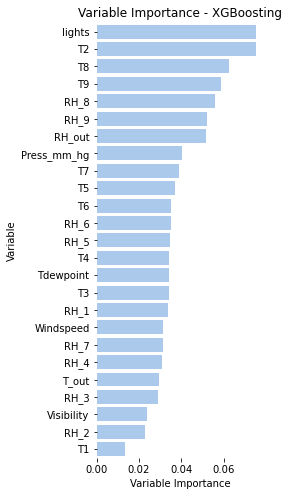

In [8]:
# Variable importance
importances = XGB_opt.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - XGBoosting")
sns.set_color_codes("pastel")
sns.barplot(y=[Xtrain.columns[i] for i in indices], x=importances[indices], 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance")
sns.despine(left=True, bottom=True)